<a href="https://colab.research.google.com/github/Lalithadevi2005/Virtual-Mouse-Using-Hand-Gestures/blob/main/Project_Pneumonia_Detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the neceessary libraries


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os


In [56]:
import os
import shutil
import random

# Paths
base_dir = '/content/drive/MyDrive/pnemonia_detection/ChestXRay2017/chest_xray'  # replace this with your actual path
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Classes
labels = ['NORMAL', 'PNEUMONIA']

# Split ratio
val_split = 0.15  # 15% for validation

# Create val/ folders
for label in labels:
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

    train_label_dir = os.path.join(train_dir, label)
    val_label_dir = os.path.join(val_dir, label)

    # Get list of files and shuffle
    files = os.listdir(train_label_dir)
    random.shuffle(files)

    val_count = int(len(files) * val_split)
    val_files = files[:val_count]

    # Move files from train to val
    for f in val_files:
        src = os.path.join(train_label_dir, f)
        dst = os.path.join(val_label_dir, f)
        shutil.move(src, dst)

print("Validation set created successfully.")


Validation set created successfully.


# Pneumonia Dataset

In [57]:
labels=['PNEUMONIA','NORMAL']
img_resize=150

def get_data(dir):
  data=[]
  for label in labels:
    path=os.path.join(dir,label)
    class_num=labels.index(label)
    for img in os.listdir(path):
      try:
        if img.endswith('jpeg'):
          img_arr=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
          resized_arr=cv2.resize(img_arr,(img_resize,img_resize))
          data.append([resized_arr,class_num])
      except Exception as e:
          print(e)
  return np.array(data,dtype='object')




In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#get the path of folder
train=get_data('/content/drive/MyDrive/pnemonia_detection/ChestXRay2017/chest_xray/train')
test=get_data('/content/drive/MyDrive/pnemonia_detection/ChestXRay2017/chest_xray/test')
val=get_data('/content/drive/MyDrive/pnemonia_detection/ChestXRay2017/chest_xray/val')


# Data Visualization and preprocessing

<Axes: xlabel='count'>

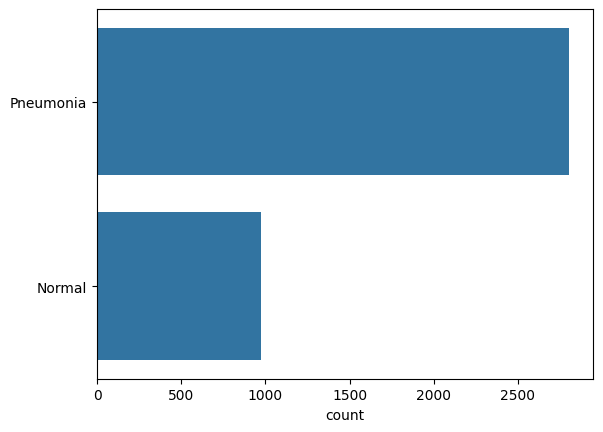

In [60]:
l=[]
for i in train:
  if (i[1]==0):
    l.append('Pneumonia')
  else:
    l.append('Normal')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

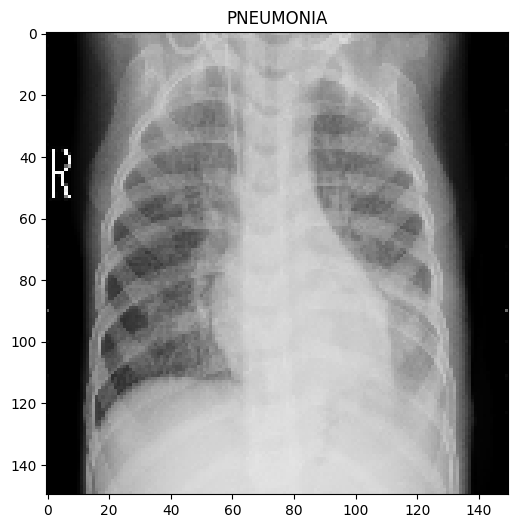

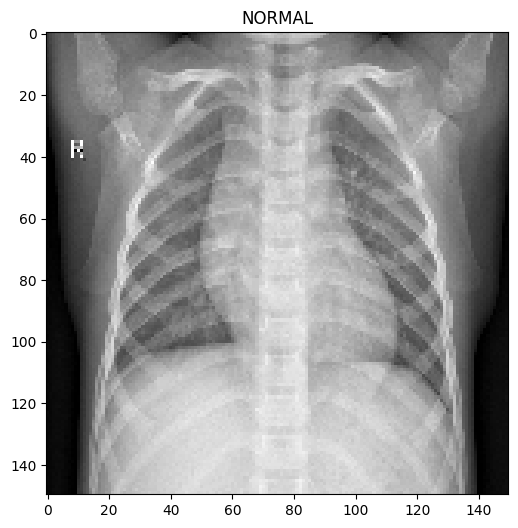

In [61]:
plt.figure(figsize=(6,6))
plt.imshow(train[0][0],cmap='gray')
plt.title(labels[train[0][1]])
plt.figure(figsize=(6,6))
plt.imshow(train[-1][0],cmap='gray')
plt.title(labels[train[-1][1]])


In [62]:
x_train=[]
y_train=[]
x_val=[]
y_val=[]
x_test=[]
y_test=[]
for feat,label in train:
  x_train.append(feat)
  y_train.append(label)
for feat,label in test:
  x_test.append(feat)
  y_test.append(label)
for feat,label in val:
  x_val.append(feat)
  y_val.append(label)

In [63]:
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255
x_val=np.array(x_val)/255

In [64]:
x_train=x_train.reshape(-1,img_resize,img_resize,1)
y_train=np.array(y_train)

x_test=x_test.reshape(-1,img_resize,img_resize,1)
y_test=np.array(y_test)
x_val=x_val.reshape(-1,img_resize,img_resize,1)
y_val=np.array(y_val)

In [65]:
datagen=ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False

)
datagen.fit(x_train)

# Training the model

In [66]:
model=Sequential()
model.add(Conv2D(32,(3,3),strides=1,padding='same',activation='relu',input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64,(3,3),strides=1,padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64,(3,3),strides=1,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(128,(3,3),strides=1,padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(256,(3,3),strides=1,padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
#rms prop
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [67]:
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.3,min_lr=0.00001)

In [68]:
history=model.fit(x_train,y_train,batch_size=32,epochs=18,
                  validation_data=datagen.flow(x_val,y_val),
                  callbacks=[learning_rate_reduction])

Epoch 1/18
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8201 - loss: 1.7797

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.8206 - loss: 1.7701 - val_accuracy: 0.7421 - val_loss: 3.3196 - learning_rate: 0.0010
Epoch 2/18
119/119 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.9319 - loss: 0.1774 - val_accuracy: 0.7421 - val_loss: 5.0281 - learning_rate: 0.0010
Epoch 3/18
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9603 - loss: 0.1030
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
119/119 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.9603 - loss: 0.1030 - val_accuracy: 0.6359 - val_loss: 1.8508 - learning_rate: 0.0010
Epoch 4/18
119/119 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.9851 - loss: 0.0449 - val_accuracy: 0.7407 - val_loss: 6.7128 - learning_rate: 3.0000e-04
Epoch 5/18
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9917 - loss: 0.0208
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
119/119 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.9917 - loss: 0.0208 - val_ac

In [69]:
model.evaluate(x_test,y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 529ms/step - accuracy: 0.9212 - loss: 0.9305


[3.37233567237854, 0.7291666865348816]

In [70]:
print(f"loss of the model is {model.evaluate(x_test,y_test)[0]}")
print(f"Accuracy of the model is {model.evaluate(x_test,y_test)[1]*100}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - accuracy: 0.9212 - loss: 0.9305
loss of the model is 3.37233567237854
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step - accuracy: 0.9212 - loss: 0.9305
Accuracy of the model is 72.91666865348816%


# Analyse Model Performance

In [ ]:
epochs=[i for i in range(18)]
fig,ax=plt.subplots(1,2)
train_acc=history.history['accuracy']
train_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
fig.set_size_inches(20,10)
ax[0].plot(epochs,train_acc,'go-',label='Training accuracy')
ax[0].plot(epochs,val_acc,'ro-',label='Validation accuracy')
ax[0].set_title("training & validation accuracy ")
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("Accuray")

ax[1].plot(epochs,train_loss,'g-o',label='Training loss')
ax[1].plot(epochs,val_loss,'r-o',label='Validation loss')
ax[1].set_title("training & validation loss")
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("loss")


In [ ]:
predict=(model.predict(x_test)>0.5).astype('int32')
predict=predict.reshape(1,-1)[0]
predict[:15]

In [73]:
print(classification_report(y_test,predict,target_names=['Pnemonia(Class 0)','Normal(Class 1)']))

                   precision    recall  f1-score   support

Pnemonia(Class 0)       0.70      1.00      0.82       390
  Normal(Class 1)       1.00      0.28      0.43       234

         accuracy                           0.73       624
        macro avg       0.85      0.64      0.63       624
     weighted avg       0.81      0.73      0.68       624



In [74]:
cm=confusion_matrix(y_test,predict)


In [75]:
cm

array([[390,   0],
       [169,  65]])

In [76]:
correct=np.nonzero(predict==y_test)[0]
incorrect=np.nonzero(predict!=y_test)[0]

# Some corectly predicted Classes

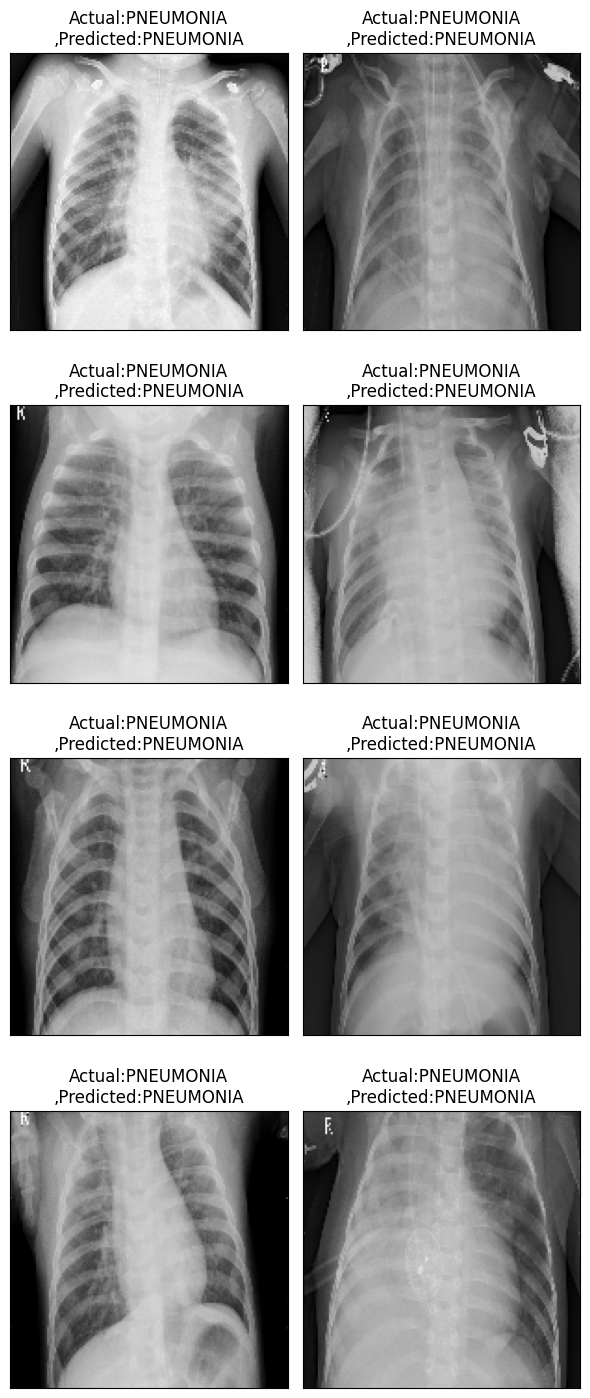

In [77]:
i=0
plt.figure(figsize=(6,15))
for c in correct[10:18]:
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(x_test[c].reshape(150,150),cmap='gray')
  plt.title(f"Actual:{labels[y_test[c]]}\n,Predicted:{labels[predict[c]]}")
  plt.tight_layout()
  i+=1


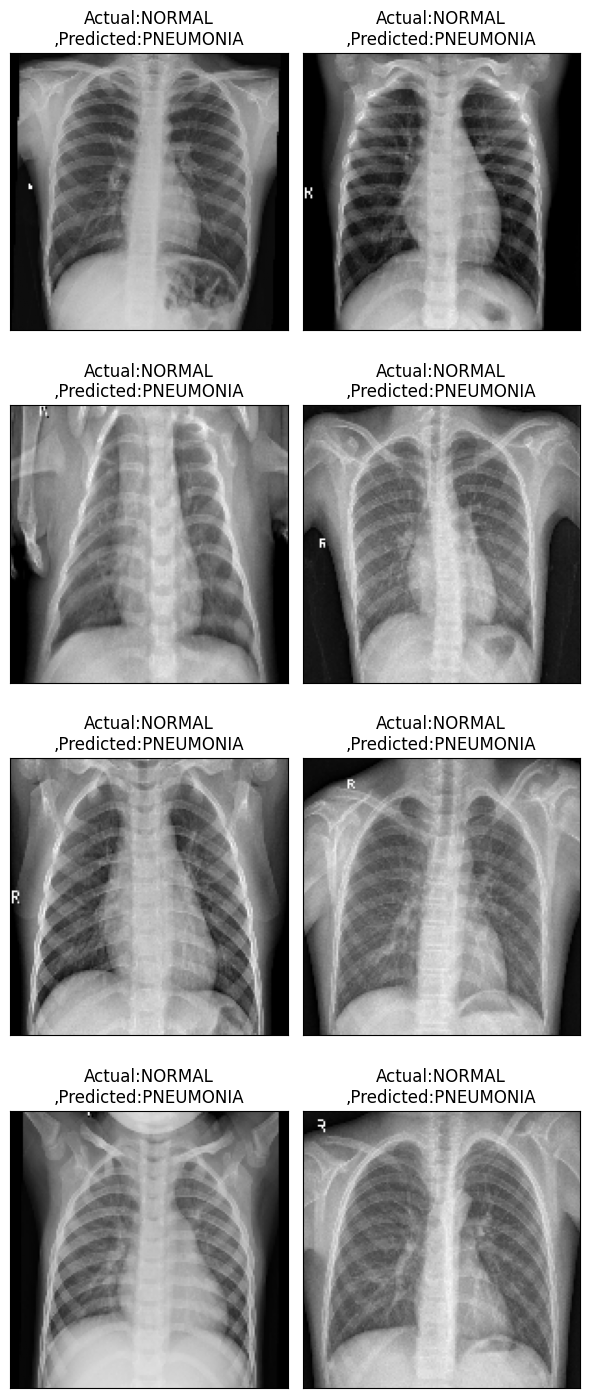

In [78]:
i=0
plt.figure(figsize=(6,15))
for c in incorrect[10:18]:
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(x_test[c].reshape(150,150),cmap='gray')
  plt.title(f"Actual:{labels[y_test[c]]}\n,Predicted:{labels[predict[c]]}")
  plt.tight_layout()
  i+=1
